In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from fcmeans import FCM
import scikit_posthocs as sci_posthocs

import scipy as sci
import matplotlib
from sklearn.cluster import KMeans

import analysis as ana
import plot as pl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [4]:
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)
font = {'family':'CMU Serif', 
               #'sans-serif':['Helvetica'],
               'size': 11}
mpl.rc('font', **font)

# Lodaing Data

In [5]:
brain_data_z, cog_data_z, subj_data = ana.load_data('../data_zscore')
brain_data, cog_data, _ = ana.load_data('../data')
data_z_all = cog_data_z.join(brain_data_z)

'In good health': 0, 

'Affective psychosis': 1, 

'Non-affective psychosis': 2

In [6]:
subj_data['phenotype_description'].value_counts()

2    84
0    46
1    25
Name: phenotype_description, dtype: int64

# PCA

### cognitive features

In [7]:
pca = PCA(6)
pca.fit_transform(cog_data_z)
components = pca.components_
cog_data_z_pca = pca.transform(cog_data_z) # project the original data into the PCA space

In [8]:
pca = PCA(4)
pca.fit(brain_data_z)
components = pca.components_
brain_data_z_pca = pca.transform(brain_data_z)

In [9]:
pca = PCA(9)
pca.fit_transform(data_z_all)
components = pca.components_
data_z_pca = pca.transform(data_z_all)

# FA

In [8]:
brain_data_z_m = brain_data_z.drop(['23', '24', '28'], axis=1)
fa = FactorAnalyzer(7, rotation=None)
fa.fit(brain_data_z_m)
brain_data_z_fa = fa.transform(brain_data_z_m)

In [9]:
all_data_z_pcafa = np.concatenate((cog_data_z_pca, brain_data_z_fa), axis=1)
all_data_z_pcafa.shape

(155, 13)

# Fuzzy clustering

**partition_coefficient**:
defined on the range from 0 to 1, with 1 being best. It is a metric which tells us how cleanly our data is described by a certain model.


**partition_entropy_coefficient**: The partition entropy (PE) measures the fuzzy degree of final divided clusters by means of the fuzzy partition matrix, and the smaller its value, the better the partition result

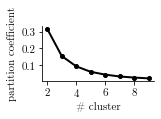

In [307]:
K, pc_list, pec_list = ana.get_partition(cog_data_z_pca, 9)
pl.plot_clustering_validation(K, pc_list, 'partition coefficient')

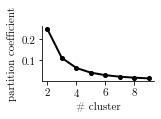

In [308]:
K, pc_list, pec_list = ana.get_partition(brain_data_z_fa, 9)
pl.plot_clustering_validation(K, pc_list, 'partition coefficient')

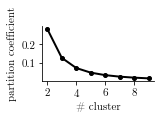

In [300]:
K, pc_list, pec_list = ana.get_partition(all_data_z_pcafa, 9)
pl.plot_clustering_validation(K, pc_list, 'partition coefficient')

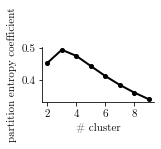

In [301]:
pl.plot_clustering_validation(K, pec_list, 'partition entropy coefficient')

all Data, cog-PCA (z), brain-FA (z)


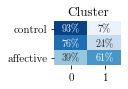

In [14]:
print('all Data, cog-PCA (z), brain-FA (z)')
predict, df = ana.Fuzzy(all_data_z_pcafa, 2)
pl.plot_cluster_result(df,2,patients_only=False)

In [11]:
k = 3

Cognitive Data, PCA


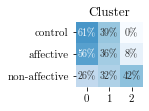

In [26]:
print('Cognitive Data, PCA')
predict_cog, df = ana.Fuzzy(cog_data_z_pca, k, random_state=9)
pl.plot_cluster_result(df, k)
#plt.savefig('fig/Clu_cog.svg', dpi=500, bbox_inches='tight')

In [27]:
clu_all_result = pd.DataFrame(index=cog_data.index)
clu_all_result['predict_cog'] = predict_cog
clu_all_result['phenotype_description'] = subj_data['phenotype_description']
clu_all_result.to_csv('clu_results/clu_results_all_cog.txt', sep=',')

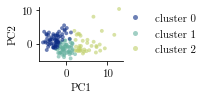

In [140]:
pl.plot_data_2D(cog_data_z_pca, group=predict_cog, cluster=True)
plt.savefig('fig/clu_data_cog.svg', dpi=500, bbox_inches='tight')

Brain Data, FA


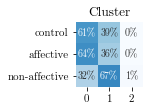

In [137]:
print('Brain Data, FA')
predict_brain, df = ana.Fuzzy(brain_data_z_fa, k, random_state=9)
pl.plot_cluster_result(df, k)

all Data, cog-PCA (z), brain-FA (z)


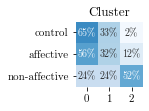

In [12]:
print('all Data, cog-PCA (z), brain-FA (z)')
predict_all, df = ana.Fuzzy(all_data_z_pcafa, k,random_state=8)
pl.plot_cluster_result(df, k)
plt.savefig('fig/clu_comb.svg', dpi=500, bbox_inches='tight')

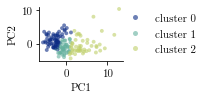

In [30]:
pl.plot_data_2D(cog_data_z_pca, group=predict_all, cluster=True)
plt.savefig('fig/clu_data_comb_s.svg', dpi=500, bbox_inches='tight')

In [13]:
clu_all_result = pd.DataFrame(index=cog_data.index)
clu_all_result['predict_all'] = predict_all
clu_all_result['phenotype_description'] = subj_data['phenotype_description']
clu_all_result.to_csv('clu_results/clu_results_all.txt', sep=',')
clu_all_result['predict_all'].value_counts()

0    64
2    48
1    43
Name: predict_all, dtype: int64

# Cluster Analysis

In [105]:
clinical_data = pd.read_csv('../data/clinical.txt', index_col=0)
clinical_data = clinical_data.reindex(subj_data.index)

In [106]:
clinical_data['cluster'] = predict_all
clinical_data_patients = clinical_data.dropna(axis='rows')
clu_0, clu_1, clu_2 = ana.get_cluster_data(clinical_data_patients, 0), ana.get_cluster_data(clinical_data_patients, 1), ana.get_cluster_data(clinical_data_patients, 2)
col_panss = ['panss_total','panss_pos','panss_neg','general']
col_panss_names = ['PANSS total', 'PANSS positiv', 'PANSS negativ', 'general psychopathology']
df_comparison = ana.group_comparison(clinical_data_patients, col_panss, cluster=True)

In [107]:
df_comparison

,panss_total,panss_pos,panss_neg,general
test,,,,
group,"[16.7653, 0.0002]","[2.1795, 0.3363]","[24.6943, 0.0]","[6.4849, 0.0391]"
0-1,"[0.0289, 0.8997]",-,"[0.3163, 0.637]","[0.3985, 0.5941]"
0-2,"[12.0846, 0.0006]",-,"[16.5189, 0.0001]","[5.4812, 0.0159]"
1-2,"[11.2162, 0.0007]",-,"[17.6665, 0.0]","[3.1663, 0.0882]"


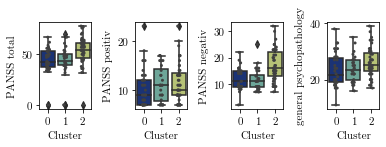

In [132]:
pl.plot_boxplots(clinical_data_patients, col_panss, col_panss_names, 1,4)
plt.savefig('fig/clu_panss.svg', dpi=500, bbox_inches='tight')

In [14]:
cog_data_cluster = cog_data.copy()
subj_data_pat = subj_data[subj_data.phenotype != 0]
cog_data_cluster_pat = cog_data_cluster[subj_data.phenotype != 0]
cog_data_cluster_con = cog_data_cluster[subj_data.phenotype == 0]

In [15]:
cog_data_cluster['cluster'] = predict_all
cog_data_cluster = cog_data_cluster[subj_data.phenotype != 0]
clu_0, clu_1, clu_2 = ana.get_cluster_data(cog_data_cluster, 0), ana.get_cluster_data(cog_data_cluster, 1), ana.get_cluster_data(cog_data_cluster, 2)
col_cog = ['cogcomp01_nih_fluidcogcomp_unadjusted', 'acpt01_auditory_t11',
       'cogcomp01_nih_crycogcomp_unadjusted', 'wasi201_iqscores_full2iq',
       'acpt01_auditory_t14', 'orrt01_read_acss', 'tpvt01_tpvt_acss',
       'lswmt01_tbx_ls', 'acpt01_auditory_t9', 'acpt01_auditory_t6']
col_cog_names = ['Fluid cognition', 'Auditory attention t11',
       'Crystallized cognition', 'Total IQ',
       'Auditory attention t14', 'Oral reading recognition', 'Picture vocabulary test',
       'Working memory', 'Auditory attention t9', 'Auditory attention t6']
df_comparison = ana.group_comparison(cog_data_cluster, col_cog, cluster=True)
df_comparison.columns = col_cog_names

In [33]:
df_comparison

,Fluid cognition,Auditory attention t11,Crystallized cognition,Total IQ,Auditory attention t14,Oral reading recognition,Picture vocabulary test,Working memory,Auditory attention t9,Auditory attention t6
test,,,,,,,,,,
group,"[45.6227, 0.0]","[39.7392, 0.0]","[68.8304, 0.0]","[51.4924, 0.0]","[36.9545, 0.0]","[58.2129, 0.0]","[60.9789, 0.0]","[43.0473, 0.0]","[25.2787, 0.0]","[24.6697, 0.0]"
0-1,"[1.8304, 0.3566]","[0.8902, 0.6098]","[2.8433, 0.2782]","[1.0251, 0.3212]","[1.3525, 0.4054]","[0.7475, 0.497]","[1.7709, 0.3395]","[2.0384, 0.2091]","[0.048, 0.9254]","[0.048, 0.9321]"
0-2,"[35.0173, 0.0]","[28.7055, 0.0]","[51.8509, 0.0]","[43.3934, 0.0]","[28.7995, 0.0]","[45.4593, 0.0]","[47.3309, 0.0]","[36.6332, 0.0]","[18.0255, 0.0]","[17.513, 0.0]"
1-2,"[27.1038, 0.0]","[26.1816, 0.0]","[42.0413, 0.0]","[26.8764, 0.0]","[21.5207, 0.0]","[34.7952, 0.0]","[36.044, 0.0]","[21.1106, 0.0]","[16.5231, 0.0001]","[16.2267, 0.0001]"


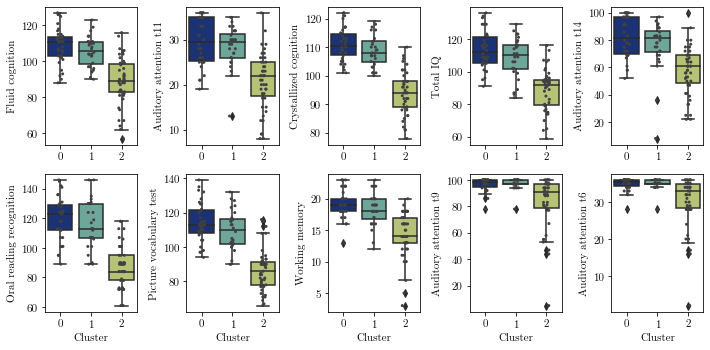

In [114]:
pl.plot_boxplots(cog_data_cluster, col_cog, col_cog_names)
#plt.savefig('fig/clu_cog.svg', dpi=500, bbox_inches='tight')

## selected features

In [17]:
cog_data_cluster = cog_data.copy()
cog_data_cluster['cluster'] = predict_all
cog_data_cluster.loc[subj_data.phenotype == 0, 'cluster'] = 'c'
col_cog = list(cog_data.columns)[4:]
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog)

In [25]:
#print(df_comparison.T.to_latex(index=True))  

In [18]:
col_cog_repr = ['flanker01_nih_flanker_ageadjusted',
'lswmt01_tbx_ls',
'orrt01_read_acss',
'pcps01_nih_patterncomp_ageadjusted',
'tpvt01_tpvt_acss',
'wasi201_vocab_totalrawscore',
'wasi201_matrix_totalrawscore',
'wasi201_iqscores_full2iq',
'cogcomp01_nih_fluidcogcomp_unadjusted',
'cogcomp01_nih_crycogcomp_unadjusted',
'deldisk01_auc_40000',
'dccs01_nih_dccs_ageadjusted',
'er4001_er40_c_cr',
'acpt01_auditory_t14']
col_cog_names_repr = ['Selective attention/ executive control (Age Adj.)', 
'Working memory',
'Oral reading recognition', 
'Pattern Comparison Processing Speed (Age Adj.)',
'Picture Vocabulary Test (Age Adj.)',
'WASI-2 Total - Vocabulary',                  
'WASI-2 Total - Matrix Reasoning',                      
'WASI-2 Full IQ',
'Fluid cognition',
'Crystallized cognition',
'Delay Discounting Task AUC \$40000', #Delay Discounting Task Area Under the Curve for Delay Amount \$40000
'Dimensional Change Card Sort Test (Age Adj.)', #Age Adjusted scaled score for Dimensional Change Card Sort Test subtest  
'Penn Emotion Recognition Task Correct Responses',
'Auditory attention %Hits']

In [19]:
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog_repr)
df_comparison

,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,deldisk01_auc_40000,dccs01_nih_dccs_ageadjusted,er4001_er40_c_cr,acpt01_auditory_t14
test,,,,,,,,,,,,,,
group,"[47.846, 0.0]","[53.3758, 0.0]","[70.2308, 0.0]","[23.0322, 0.0]","[72.5704, 0.0]","[63.7426, 0.0]","[52.0876, 0.0]","[73.7482, 0.0]","[67.3415, 0.0]","[81.0281, 0.0]","[58.1215, 0.0]","[42.7631, 0.0]","[33.827, 0.0]","[64.2906, 0.0]"
0-1,"[0.5109, 0.5429]","[2.0384, 0.1997]","[0.7475, 0.4511]","[1.447, 0.2354]","[1.7709, 0.3024]","[1.0729, 0.3139]","[0.49, 0.5084]","[1.0251, 0.3126]","[1.8304, 0.3128]","[2.8433, 0.2392]","[32.1893, 0.0]","[0.2892, 0.6112]","[0.7642, 0.3739]","[1.3525, 0.2834]"
0-2,"[22.5686, 0.0]","[36.6332, 0.0]","[45.4593, 0.0]","[10.4729, 0.0011]","[47.3309, 0.0]","[38.9171, 0.0]","[27.6299, 0.0]","[43.3934, 0.0]","[35.0173, 0.0]","[51.8509, 0.0]","[36.5371, 0.0]","[21.0286, 0.0]","[16.1314, 0.0001]","[28.7995, 0.0]"
0-c,"[1.2216, 0.252]","[0.0733, 0.7344]","[0.8578, 0.4547]","[0.8921, 0.3406]","[0.0077, 0.9086]","[0.0721, 0.7834]","[2.8483, 0.1754]","[1.4479, 0.3366]","[1.8349, 0.2555]","[0.0481, 0.7143]","[7.0386, 0.0266]","[1.9385, 0.2087]","[1.3997, 0.2514]","[2.8254, 0.0956]"
1-2,"[20.0192, 0.0001]","[21.1106, 0.0]","[34.7952, 0.0]","[3.4935, 0.0701]","[36.044, 0.0]","[24.0036, 0.0]","[17.7603, 0.0001]","[26.8764, 0.0]","[27.1038, 0.0]","[42.0413, 0.0]","[0.622, 0.7487]","[15.1413, 0.0002]","[7.7718, 0.0049]","[21.5207, 0.0001]"
1-c,"[4.7786, 0.0839]","[1.3684, 0.2959]","[0.0125, 0.9228]","[4.8505, 0.0306]","[1.8664, 0.3223]","[1.8752, 0.183]","[4.853, 0.0474]","[5.0548, 0.0475]","[6.5861, 0.0317]","[1.6186, 0.364]","[17.053, 0.0001]","[3.6779, 0.0841]","[4.1371, 0.0425]","[11.0376, 0.0066]"
2-c,"[38.8768, 0.0]","[37.001, 0.0]","[47.8634, 0.0]","[20.6746, 0.0]","[48.0904, 0.0]","[50.1769, 0.0]","[41.5867, 0.0]","[57.2238, 0.0]","[52.1049, 0.0]","[52.9568, 0.0]","[23.5871, 0.0]","[35.7623, 0.0]","[30.6823, 0.0]","[52.916, 0.0]"


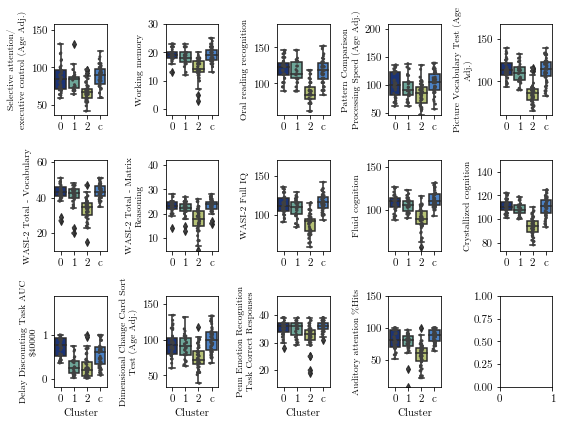

In [20]:
pl.plot_boxplots(cog_data_cluster, col_cog_repr, col_cog_names_repr, 3,5,control=True)
plt.savefig('fig/clu_cog_repr.svg', dpi=500, bbox_inches='tight')

## all features

In [22]:
cog_data_cluster = cog_data.copy()
cog_data_cluster['cluster'] = predict_all
cog_data_cluster.loc[subj_data.phenotype == 0, 'cluster'] = 'c'
clu_0, clu_1, clu_2, con = ana.get_cluster_data(cog_data_cluster, 0), ana.get_cluster_data(cog_data_cluster, 1), ana.get_cluster_data(cog_data_cluster, 2), ana.get_cluster_data(cog_data_cluster, 'c')
col_cog = list(cog_data.columns)[4:]
#col_cog_names = []
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog)
#df_comparison.columns = col_cog_names

In [28]:
df_comparison.T

test,group,0-1,0-2,0-c,1-2,1-c,2-c
acpt01_auditory_t1,"[35.6453, 0.0]","[0.0986, 0.7735]","[10.2553, 0.0012]","[4.5688, 0.0302]","[14.8106, 0.0008]","[5.2392, 0.0821]","[30.6626, 0.0]"
acpt01_auditory_t3,"[25.9438, 0.0]","[0.0001, 0.9851]","[10.7564, 0.0005]","[1.096, 0.3884]","[9.621, 0.0009]","[0.9417, 0.4273]","[20.29, 0.0]"
acpt01_auditory_t4,"[37.3924, 0.0]","[0.0693, 0.8137]","[11.1998, 0.0007]","[4.56, 0.0303]","[15.8891, 0.0006]","[5.7417, 0.0729]","[31.5816, 0.0]"
acpt01_auditory_t5,"[11.5539, 0.0091]","[0.1801, 0.6526]","[7.1802, 0.0056]","[0.0258, 0.9509]","[4.4005, 0.0331]","[0.1701, 0.6736]","[9.0972, 0.0033]"
acpt01_auditory_t6,"[42.4216, 0.0]","[0.048, 0.8377]","[17.513, 0.0]","[3.4265, 0.1156]","[16.2267, 0.0002]","[5.1509, 0.0886]","[34.0509, 0.0]"
acpt01_auditory_t8,"[26.0444, 0.0]","[0.5681, 0.487]","[8.8137, 0.0019]","[1.8437, 0.2126]","[12.7535, 0.0002]","[0.3613, 0.6628]","[20.6534, 0.0]"
acpt01_auditory_t9,"[42.9863, 0.0]","[0.048, 0.8319]","[18.0255, 0.0]","[3.4055, 0.1197]","[16.5231, 0.0002]","[5.1509, 0.0902]","[34.2688, 0.0]"
acpt01_auditory_t10,"[4.6278, 0.2012]",-,-,-,-,-,-
acpt01_auditory_t11,"[65.749, 0.0]","[0.8902, 0.4161]","[28.7055, 0.0]","[2.9106, 0.0878]","[26.1816, 0.0]","[10.4248, 0.0133]","[52.8139, 0.0]"
acpt01_auditory_t13,"[13.2943, 0.004]","[0.0915, 0.6423]","[3.7637, 0.0553]","[1.8363, 0.1591]","[1.8252, 0.1898]","[4.1121, 0.0683]","[12.5557, 0.0003]"


In [29]:
df_comparison.T.to_csv('clu_results_cog_all.csv', sep=',')

## PCA features

In [14]:
cog_data_cluster = cog_data.copy()
cog_data_cluster['cluster'] = predict_all
cog_data_cluster.loc[subj_data.phenotype == 0, 'cluster'] = 'c'
col_cog = ['cogcomp01_nih_fluidcogcomp_unadjusted', 'acpt01_auditory_t11',
       'cogcomp01_nih_crycogcomp_unadjusted', 'wasi201_iqscores_full2iq',
       'acpt01_auditory_t14', 'orrt01_read_acss', 'tpvt01_tpvt_acss',
       'lswmt01_tbx_ls', 'acpt01_auditory_t9', 'acpt01_auditory_t6']
col_cog_names = ['Fluid intelligence', 'Auditory attention t11',
       'Crystallized intelligence', 'Total IQ',
       'Auditory attention t14', 'Oral reading recognition', 'Picture vocabulary test',
       'Working memory', 'Auditory attention t9', 'Auditory attention t6']

In [15]:
clu_0, clu_1, clu_2, con = ana.get_cluster_data(cog_data_cluster, 0), ana.get_cluster_data(cog_data_cluster, 1), ana.get_cluster_data(cog_data_cluster, 2), ana.get_cluster_data(cog_data_cluster, 'c')
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog)
df_comparison.columns = col_cog_names

In [32]:
df_comparison

,Fluid intelligence,Auditory attention t11,Crystallized intelligence,Total IQ,Auditory attention t14,Oral reading recognition,Picture vocabulary test,Working memory,Auditory attention t9,Auditory attention t6
test,,,,,,,,,,
group,"[67.3415, 0.0]","[65.749, 0.0]","[81.0281, 0.0]","[73.7482, 0.0]","[64.2906, 0.0]","[70.2308, 0.0]","[72.5704, 0.0]","[53.3758, 0.0]","[42.9863, 0.0]","[42.4216, 0.0]"
0-1,"[1.8304, 0.3128]","[0.8902, 0.4161]","[2.8433, 0.2392]","[1.0251, 0.3126]","[1.3525, 0.2834]","[0.7475, 0.4511]","[1.7709, 0.3024]","[2.0384, 0.1997]","[0.048, 0.8319]","[0.048, 0.8377]"
0-2,"[35.0173, 0.0]","[28.7055, 0.0]","[51.8509, 0.0]","[43.3934, 0.0]","[28.7995, 0.0]","[45.4593, 0.0]","[47.3309, 0.0]","[36.6332, 0.0]","[18.0255, 0.0]","[17.513, 0.0]"
0-c,"[1.8349, 0.2555]","[2.9106, 0.0878]","[0.0481, 0.7143]","[1.4479, 0.3366]","[2.8254, 0.0956]","[0.8578, 0.4547]","[0.0077, 0.9086]","[0.0733, 0.7344]","[3.4055, 0.1197]","[3.4265, 0.1156]"
1-2,"[27.1038, 0.0]","[26.1816, 0.0]","[42.0413, 0.0]","[26.8764, 0.0]","[21.5207, 0.0001]","[34.7952, 0.0]","[36.044, 0.0]","[21.1106, 0.0]","[16.5231, 0.0002]","[16.2267, 0.0002]"
1-c,"[6.5861, 0.0317]","[10.4248, 0.0133]","[1.6186, 0.364]","[5.0548, 0.0475]","[11.0376, 0.0066]","[0.0125, 0.9228]","[1.8664, 0.3223]","[1.3684, 0.2959]","[5.1509, 0.0902]","[5.1509, 0.0886]"
2-c,"[52.1049, 0.0]","[52.8139, 0.0]","[52.9568, 0.0]","[57.2238, 0.0]","[52.916, 0.0]","[47.8634, 0.0]","[48.0904, 0.0]","[37.001, 0.0]","[34.2688, 0.0]","[34.0509, 0.0]"


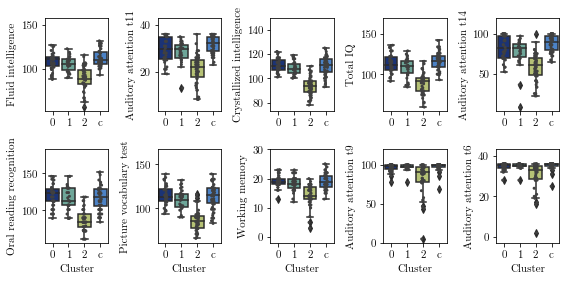

In [33]:
pl.plot_boxplots(cog_data_cluster, col_cog, col_cog_names, control=True)
plt.savefig('fig/clu_cog.svg', dpi=500, bbox_inches='tight')

# K-Means Clustering

**Intertia**:
measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

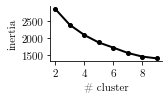

In [303]:
K, inertia = ana.get_intertia(cog_data_z_pca, 9)
pl.plot_clustering_validation(K, inertia)

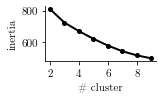

In [304]:
K, inertia = ana.get_intertia(brain_data_z_fa, 9)
pl.plot_clustering_validation(K, inertia)

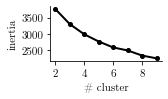

In [305]:
K, inertia = ana.get_intertia(all_data_z_pcafa, 9)
pl.plot_clustering_validation(K, inertia)

Cognitive Data, PCA
K-Means


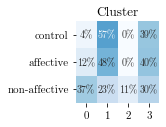

Spectral


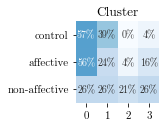

In [120]:
k=4
print('Cognitive Data, PCA')
print('K-Means')
predict, df = ana.K_Means(cog_data_z_pca, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict, df = ana.Spectral(cog_data_z_pca, k)
pl.plot_cluster_result(df, k)

Brain Data, FA
K-Means


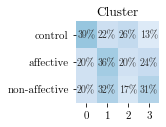

Spectral


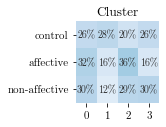

In [122]:
k=4
print('Brain Data, FA')
print('K-Means')
predict, df = ana.K_Means(brain_data_z_fa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict, df = ana.Spectral(brain_data_z_fa, k)
pl.plot_cluster_result(df, k)

all Data, cog-PCA (z), brain-FA (z)
K-Means


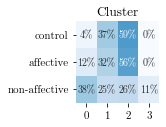

Spectral


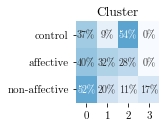

In [123]:
k=4
print('all Data, cog-PCA (z), brain-FA (z)')
print('K-Means')
predict, df = ana.K_Means(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict, df = ana.Spectral(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)

all Data, cog-PCA (z), brain-FA (z)
K-Means


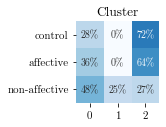

Spectral


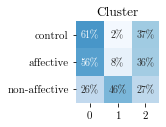

In [196]:
k=3
print('all Data, cog-PCA (z), brain-FA (z)')
print('K-Means')
predict, df = ana.K_Means(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict_spectral, df = ana.Spectral(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)